# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.


# Preparation

In [1]:
# Loading libraries
# ==============================================================
# Data processing
import pandas as pd
import numpy as np
# Plots
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuration
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [2]:
# Loading data
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
# Checking that the index is monotonic
print(f"Is The data monotonic? {data.index.is_monotonic}")

#Resampling - mean for each hour
data = data.resample('1H').sum()
data.head()

Is The data monotonic? True


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Analysis

In [4]:
# General information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


* No missing values.
* 8 months of data.

**Seasonality**

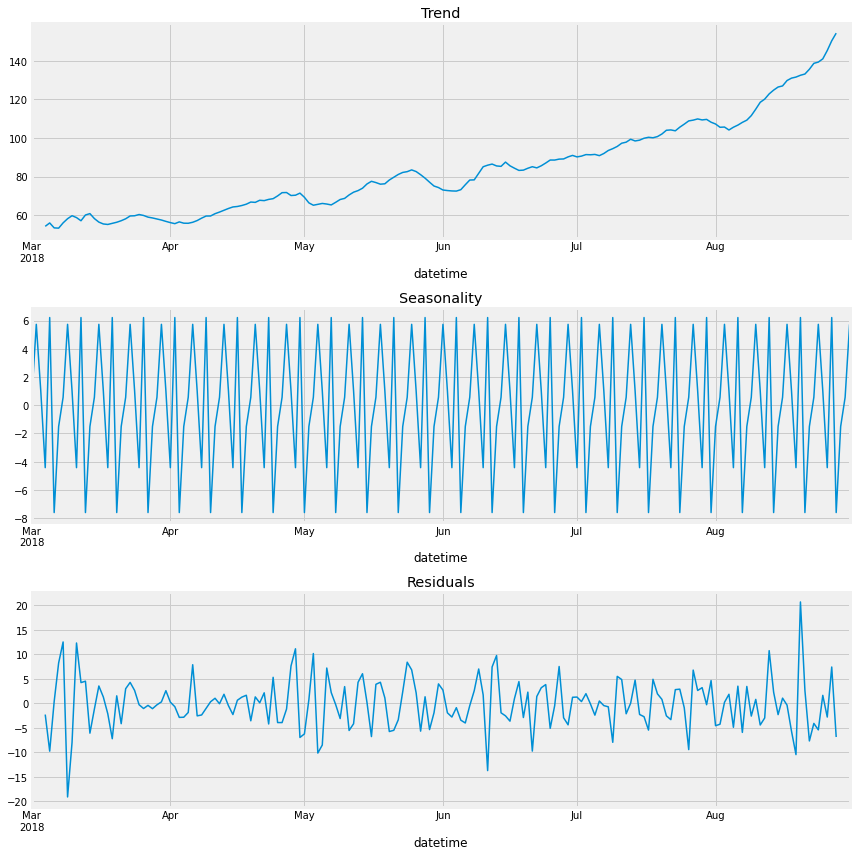

In [5]:
data_days = data.resample('1D').mean()
decomposed = seasonal_decompose(data_days)

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

We can see that the orders number is increasing through the period of the data but we dont have enough data (at least couple of years) to predict seasonality.

In [6]:
# Feature-creation function

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [7]:
# Creating features
make_features(data, 5, 7)
data.head(8)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,58.142857


## Training

In [8]:
# Split train-valid-test
end_train = '2018-07-26 03:00:00'
end_validation = '2018-08-13 13:00:00'
train = data.loc[: end_train, :]
valid   = data.loc[end_train:end_validation, :]
test  = data.loc[end_validation:, :]

# Getting rid of missing values in the train set
train = train.dropna() 

print('Proportions out of original data')
print('---------------------------------')
print(f"TRAINING set   : {train.shape[0]/data.shape[0]:.0%}")
print(f"VALIDATION set : {valid.shape[0]/data.shape[0]:.0%}")
print(f"TEST set       : {test.shape[0]/data.shape[0]:.0%}")
print('\nDates and size')
print('---------------')
print(f"Dates train      : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Dates validaion  : {valid.index.min()} --- {valid.index.max()}  (n={len(valid)})")
print(f"Dates test       : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Proportions out of original data
---------------------------------
TRAINING set   : 80%
VALIDATION set : 10%
TEST set       : 10%

Dates and size
---------------
Dates train      : 2018-03-01 07:00:00 --- 2018-07-26 03:00:00  (n=3525)
Dates validaion  : 2018-07-26 03:00:00 --- 2018-08-13 13:00:00  (n=443)
Dates test       : 2018-08-13 13:00:00 --- 2018-08-31 23:00:00  (n=443)


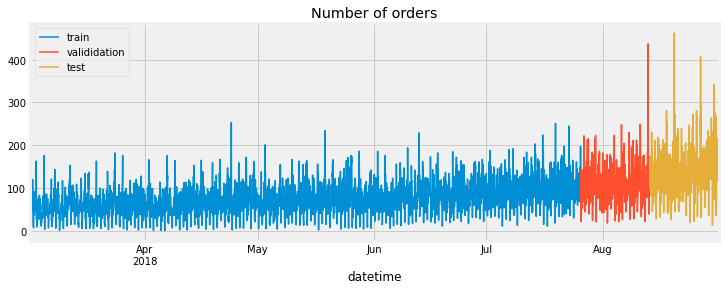

In [9]:
# Plot time series
fig, ax = plt.subplots(figsize=(11, 4))
train['num_orders'].plot(ax=ax, label='train')
valid['num_orders'].plot(ax=ax, label='valididation')
test['num_orders'].plot(ax=ax, label='test')
ax.set_title('Number of orders')
ax.legend();

In [10]:
# Spliting target and features
y_train = train['num_orders']
X_train = train.drop(['num_orders'], axis=1)
y_valid = valid['num_orders']
X_valid = valid.drop(['num_orders'], axis=1)
y_test = test['num_orders']
X_test = test.drop(['num_orders'], axis=1)

### LinearRegression

In [11]:
# Training linear regression model
lr = LinearRegression()
lr.fit(X_train,y_train)
pred_valid = lr.predict(X_valid)
pred_train = lr.predict(X_train)

print("      RMSE")
print("---------------")
print(f"Training set   : {mean_squared_error(y_train, pred_train, squared=False):.2f}")
print(f"Validation set : {mean_squared_error(y_valid, pred_valid, squared=False):.2f}")

      RMSE
---------------
Training set   : 29.02
Validation set : 40.60


### Random Forest Regressor

In [12]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=12345),
                lags      = 10 
             )
# Lags used as predictors
lags_grid = [3, 10]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:end_validation, 'num_orders'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 12,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(train)),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 12.


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [04:59<00:00, 149.75s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 1831.7478404490091



In [22]:
print(f"Best params:\n------------\n {results_grid.params.head(1).values}\n\n-------------")
print(f"RMSE : {np.sqrt(results_grid.mean_squared_error.min()):.2f}\n-------------")

Best params:
------------
 [{'max_depth': 15, 'n_estimators': 100}]

-------------
RMSE : 42.80
-------------


### XGBoost

In [23]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variabl

In [24]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [4, 7, 14, 24]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.loc[:end_validation, 'num_orders'], # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 48.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:19<00:00, 19.83s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1348.3467561477282



In [26]:
print(f"Best params:\n------------\n {results_grid.params.head(1).values}\n\n-------------")
print(f"RMSE : {np.sqrt(results_grid.mean_squared_error.min()):.2f}\n-------------")

Best params:
------------
 [{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}]

-------------
RMSE : 36.72
-------------


### CatBoost

In [27]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=12345, silent=True),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000001C70CFE33A0> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 12345} 
Creation date: 2022-11-03 18:01:45 
Last fit date: None 
Skforecast version: 0.5.1 
Python version: 3.9.7 

In [28]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [4, 7, 14, 24]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'num_orders'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                        )

Number of models compared: 48.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [02:45<00:00, 41.45s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 1262.6595144023868



In [29]:
print(f"Best params:\n------------\n {results_grid.params.head(1).values}\n\n-------------")
print(f"RMSE : {np.sqrt(results_grid.mean_squared_error.min()):.2f}\n-------------")

Best params:
------------
 [{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}]

-------------
RMSE : 35.53
-------------


### conclusion
* The best model is catboost  'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500,<Br>
    
  RMSE = 35.53

## Testing

**Testing using best model (Catboost)**

In [30]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['num_orders'],
    initial_train_size = len(data.loc[:end_validation]),
    fixed_train_size   = False,
    steps              = 1,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
    )

print(f"RMSE: {np.sqrt(metric):.2f}")

RMSE: 45.22
